# PHASE 1

In [1]:
import os
import sys
import csv
import tqdm
import tempfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
import cv2
import random
import shutil
import itertools
from sklearn.metrics import confusion_matrix, classification_report

!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = '/content/examples/lite/examples/pose_estimation/raspberry_pi'
sys.path.append(pose_sample_rpi_path)

# Download the MoveNet Thunder model
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite


Cloning into 'examples'...
remote: Enumerating objects: 23708, done.
remote: Counting objects: 100% (672/672), done.
remote: Compressing objects: 100% (412/412), done.
remote: Total 23708 (delta 218), reused 608 (delta 172), pack-reused 23036
Receiving objects: 100% (23708/23708), 44.18 MiB | 28.12 MiB/s, done.
Resolving deltas: 100% (12866/12866), done.


In [2]:
import utils
from data import BodyPart
from ml import Movenet

# Load MoveNet Thunder model
movenet = Movenet('movenet_thunder')


In [3]:
def detect(input_tensor, inference_count=3):
    image_height, image_width, channel = input_tensor.shape
    movenet.detect(input_tensor.numpy(), reset_crop_region=True)
    for _ in range(inference_count - 1):
        person = movenet.detect(input_tensor.numpy(), reset_crop_region=False)
    return person


In [4]:
def draw_prediction_on_image(image, person, crop_region=None, close_figure=True, keep_input_size=False):
    image_np = utils.visualize(image, [person])
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    im = ax.imshow(image_np)
    if close_figure:
        plt.close(fig)
    if not keep_input_size:
        image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))
    return image_np


In [5]:
import csv
import os
import sys
import tqdm
import tempfile
import tensorflow as tf

class MoveNetPreprocessor(object):
    """Helper class to preprocess pose sample images for classification."""
    def __init__(self, images_in_folder, images_out_folder, csvs_out_path):
        """Initializes a preprocessor to detect pose from images and save as CSV."""
        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_path = csvs_out_path
        self._messages = []
        self._csvs_out_folder_per_class = tempfile.mkdtemp()
        self._pose_class_names = sorted([n for n in os.listdir(self._images_in_folder) if not n.startswith('.')])

    def process(self, per_pose_class_limit=None, detection_threshold=0.1):
        """Preprocesses images in the given folder."""
        for pose_class_name in self._pose_class_names:
            print('Preprocessing', pose_class_name, file=sys.stderr)
            images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
            images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
            csv_out_path = os.path.join(self._csvs_out_folder_per_class, pose_class_name + '.csv')
            if not os.path.exists(images_out_folder):
                os.makedirs(images_out_folder)

            with open(csv_out_path, 'w') as csv_out_file:
                csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
                image_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
                if per_pose_class_limit is not None:
                    image_names = image_names[:per_pose_class_limit]
                valid_image_count = 0

                for image_name in tqdm.tqdm(image_names):
                    image_path = os.path.join(images_in_folder, image_name)
                    try:
                        image = tf.io.read_file(image_path)
                        image = tf.io.decode_jpeg(image)
                    except tf.errors.InvalidArgumentError:
                        self._messages.append('Skipped ' + image_path + '. Invalid image.')
                        continue

                    person = detect(image)
                    min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
                    should_keep_image = min_landmark_score >= detection_threshold
                    if not should_keep_image:
                        self._messages.append('Skipped ' + image_path + '. No pose was confidently detected.')
                        continue

                    valid_image_count += 1
                    output_overlay = draw_prediction_on_image(image.numpy().astype(np.uint8), person, close_figure=True, keep_input_size=True)
                    output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

                    pose_landmarks = np.array([[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score] for keypoint in person.keypoints], dtype=np.float32)
                    coordinates = pose_landmarks.flatten().astype(np.str).tolist()
                    csv_out_writer.writerow([image_name] + coordinates)

                if not valid_image_count:
                    raise RuntimeError('No valid images found for the "{}" class.'.format(pose_class_name))

        print('\n'.join(self._messages))
        all_landmarks_df = self._all_landmarks_as_dataframe()
        all_landmarks_df.to_csv(self._csvs_out_path, index=False)

    def class_names(self):
        """List of classes found in the training dataset."""
        return self._pose_class_names

    def _all_landmarks_as_dataframe(self):
        """Merge all per-class CSVs into a single dataframe."""
        total_df = None
        for class_index, class_name in enumerate(self._pose_class_names):
            csv_out_path = os.path.join(self._csvs_out_folder_per_class, class_name + '.csv')
            per_class_df = pd.read_csv(csv_out_path, header=None)
            per_class_df['class_no'] = [class_index] * len(per_class_df)
            per_class_df['class_name'] = [class_name] * len(per_class_df)
            per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') + per_class_df[per_class_df.columns[0]].astype(str))
            if total_df is None:
                total_df = per_class_df
            else:
                total_df = pd.concat([total_df, per_class_df], axis=0)

        header_name = ['file_name'] + [f"{bp.name}_x" for bp in BodyPart] + [f"{bp.name}_y" for bp in BodyPart] + [f"{bp.name}_score" for bp in BodyPart]
        header_map = {total_df.columns[i]: header_name[i] for i in range(len(header_name))}
        total_df.rename(header_map, axis=1, inplace=True)
        return total_df


--2023-11-29 09:57:59--  https://cdn.discordapp.com/attachments/705978420089192485/1055721549996499066/cachedImage.jpg
Resolving cdn.discordapp.com (cdn.discordapp.com)... 162.159.130.233, 162.159.133.233, 162.159.134.233, ...
Connecting to cdn.discordapp.com (cdn.discordapp.com)|162.159.130.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39722 (39K) [image/jpeg]
Saving to: ‘/tmp/image.jpeg’

/tmp/image.jpeg     100%[===================>]  38.79K  --.-KB/s    in 0.01s   

2023-11-29 09:57:59 (3.53 MB/s) - ‘/tmp/image.jpeg’ saved [39722/39722]



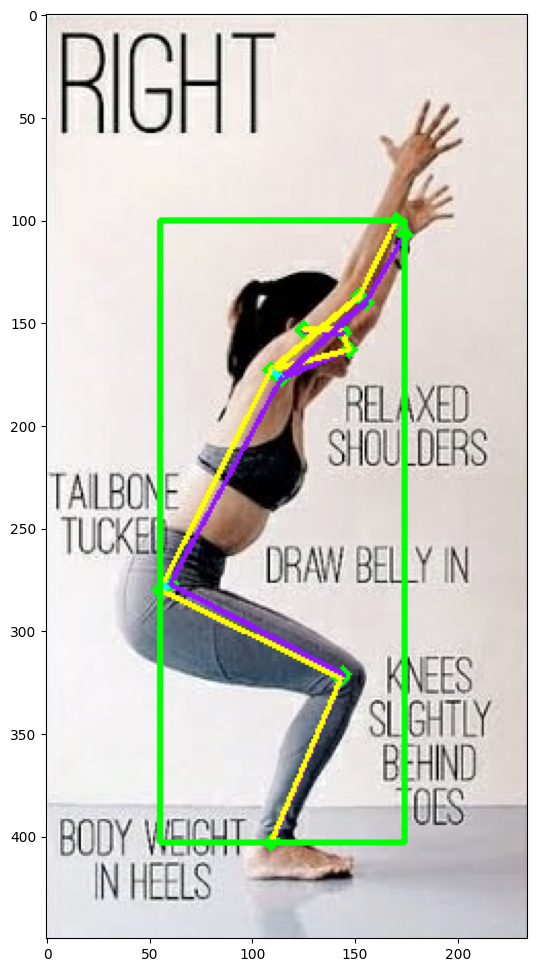

In [6]:
test_image_url = "https://cdn.discordapp.com/attachments/705978420089192485/1055721549996499066/cachedImage.jpg"
!wget -O /tmp/image.jpeg {test_image_url}

if test_image_url:
    image = tf.io.read_file('/tmp/image.jpeg')
    image = tf.io.decode_jpeg(image)
    person = detect(image)
    _ = draw_prediction_on_image(image.numpy(), person, crop_region=None, close_figure=False, keep_input_size=True)


In [7]:
import os
import requests
from tqdm import tqdm

def download_image(image_url, save_path):
    """Download an image from a given URL with exception handling."""
    try:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        response = requests.get(image_url, verify=False)  # Skipping SSL verification
        with open(save_path, 'wb') as file:
            file.write(response.content)
    except requests.exceptions.ConnectionError as e:
        print(f"Connection error for {image_url}: {e}")
    except requests.exceptions.SSLError as e:
        print(f"SSL error occurred while downloading {image_url}: {e}")
    except Exception as e:
        print(f"Error downloading {image_url}: {e}")




def process_pose_files(pose_files_dir, download_dir):
    """Process each pose file to download images."""
    for filename in os.listdir(pose_files_dir):
        if filename.endswith(".txt"):
            file_path = os.path.join(pose_files_dir, filename)
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split('\t')  # Splitting by tab character
                    if len(parts) == 2:
                        image_path, image_url = parts
                        save_path = os.path.join(download_dir, image_path)
                        if not os.path.exists(save_path):
                            download_image(image_url, save_path)
                    else:
                        print(f"Skipping line due to unexpected format: {line}")


def create_train_test_split(train_file, test_file, dataset_dir, train_dir, test_dir):
    """Create train and test datasets."""
    for split_file, split_dir in [(train_file, train_dir), (test_file, test_dir)]:
        with open(split_file, 'r') as file:
            for line in file:
                image_path, _, _, _ = line.strip().split(',')
                source_path = os.path.join(dataset_dir, image_path)
                target_path = os.path.join(split_dir, image_path)
                os.makedirs(os.path.dirname(target_path), exist_ok=True)
                shutil.copyfile(source_path, target_path)

# Define paths
pose_files_dir = '/content/drive/MyDrive/endsem_Project/v5_Yoga_/Data/Yoga-82/yoga_dataset_links'  # Directory containing the 82 pose text files
download_dir = '/content/drive/MyDrive/endsem_Project/v5_Yoga_/Data/Yoga-82/Images'  # Directory to save downloaded images
train_file = '/content/drive/MyDrive/endsem_Project/v5_Yoga_/Data/Yoga-82/yoga_train.txt'  # Path to the yoga_train.txt file
test_file = '/content/drive/MyDrive/endsem_Project/v5_Yoga_/Data/Yoga-82/yoga_test.txt'  # Path to the yoga_test.txt file
train_dir = '/content/drive/MyDrive/endsem_Project/v5_Yoga_/Data/Yoga-82/train_dir'  # Directory to store training images
test_dir = '/content/drive/MyDrive/endsem_Project/v5_Yoga_/Data/Yoga-82/test_dir'  # Directory to store testing images

# # Step 1: Download and Save Images
# print("Downloading images...")
# process_pose_files(pose_files_dir, download_dir)

# # Step 2: Create Train/Test Split
# print("Creating train/test split...")
# create_train_test_split(train_file, test_file, download_dir, train_dir, test_dir)

# print("Dataset preparation complete.")


In [8]:
# def split_into_train_test(images_origin, images_dest, test_split):
#     _, dirs, _ = next(os.walk(images_origin))
#     TRAIN_DIR = os.path.join(images_dest, 'train')
#     TEST_DIR = os.path.join(images_dest, 'test')
#     os.makedirs(TRAIN_DIR, exist_ok=True)
#     os.makedirs(TEST_DIR, exist_ok=True)

#     for dir in dirs:
#         filenames = os.listdir(os.path.join(images_origin, dir))
#         filenames = [os.path.join(images_origin, dir, f) for f in filenames if (f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
#         filenames.sort()
#         random.seed(42)
#         random.shuffle(filenames)
#         test_count = int(len(filenames) * test_split)
#         for i, file in enumerate(filenames):
#             if i < test_count:
#                 destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
#             else:
#                 destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
#             os.makedirs(os.path.dirname(destination), exist_ok=True)
#             shutil.copyfile(file, destination)
#         print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')

#     print(f'Your split dataset is in "{images_dest}"')

# # Usage example
# origin = "/content/drive/MyDrive/endsem_Project/v5_Yoga_/Data/Yoga-82/Images"
# dest = "/content/drive/MyDrive/endsem_Project/v5_Yoga_/Data/Output_Pose_detected"
# split_into_train_test(origin, dest, 0.2)  # 20% split


#PHASE 2

In [9]:
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def load_pose_landmarks(csv_path):
    dataframe = pd.read_csv(csv_path)
    df_to_process = dataframe.copy()
    df_to_process.drop(columns=['file_name'], inplace=True)
    classes = df_to_process.pop('class_name').unique()
    y = df_to_process.pop('class_no')
    X = df_to_process.astype('float64')
    y = to_categorical(y)
    return X, y, classes, dataframe

# Load Train and Test Data
csvs_out_train_path = '/content/drive/MyDrive/endsem_Project/v5_Yoga_/Data/Phase1_output/train_data.csv'
csvs_out_test_path = '/content/drive/MyDrive/endsem_Project/v5_Yoga_/Data/Phase1_output/test_data.csv'

X_train, y_train, class_names, _ = load_pose_landmarks(csvs_out_train_path)
X_test, y_test, _, _ = load_pose_landmarks(csvs_out_test_path)

# Split Training Data into Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)


In [10]:
import tensorflow as tf
from data import BodyPart

def get_center_point(landmarks, left_bodypart, right_bodypart):
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    return (left + right) * 0.5

def get_pose_size(landmarks, torso_size_multiplier=2.5):
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)
    torso_size = tf.linalg.norm(shoulders_center - hips_center)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
    d = landmarks - tf.expand_dims(pose_center, 1)  # Ensure broadcasting is done correctly
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=2))
    return tf.maximum(torso_size * torso_size_multiplier, max_dist)

def normalize_pose_landmarks(landmarks):
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
    landmarks -= tf.expand_dims(pose_center, 1)  # Adjust broadcasting
    pose_size = get_pose_size(landmarks)
    return landmarks / pose_size

def landmarks_to_embedding(landmarks_and_scores):
    reshaped_inputs = tf.keras.layers.Reshape((17, 3))(landmarks_and_scores)
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])
    return tf.keras.layers.Flatten()(landmarks)


In [11]:
from keras.layers import Dense, Dropout, Input
from keras.models import Model

# Define the model
input_shape = (51,)  # Assuming input feature vector size is 51
inputs = Input(shape=input_shape)
embedding = landmarks_to_embedding(inputs)
layer = Dense(128, activation='relu')(embedding)
layer = Dropout(0.5)(layer)
layer = Dense(64, activation='relu')(layer)
layer = Dropout(0.5)(layer)
outputs = Dense(len(class_names), activation="softmax")(layer)
model = Model(inputs, outputs)

# Model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 17, 3)                0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 17, 2)                0         ['reshape[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpL  (None, 2)                    0         ['tf.__operators__.getitem

input_1 (type: InputLayer):
    Input shape: [(None, 51)]
    Output shape: [(None, 51)]
    Trainable: True

tf.__operators__.getitem (type: SlicingOpLambda):
    Input shape: (None, 17, 3)
    Output shape: (None, 17, 2)
    Trainable: True

dense (type: Dense):
    Input shape: (None, 34)
    Output shape: (None, 128)
    Trainable: True
    Units: 128
    Activation: relu

dense_1 (type: Dense):
    Input shape: (None, 128)
    Output shape: (None, 64)
    Trainable: True
    Units: 64
    Activation: relu

dense_2 (type: Dense):
    Input shape: (None, 64)
    Output shape: (None, 5)
    Trainable: True
    Units: 5
    Activation: softmax



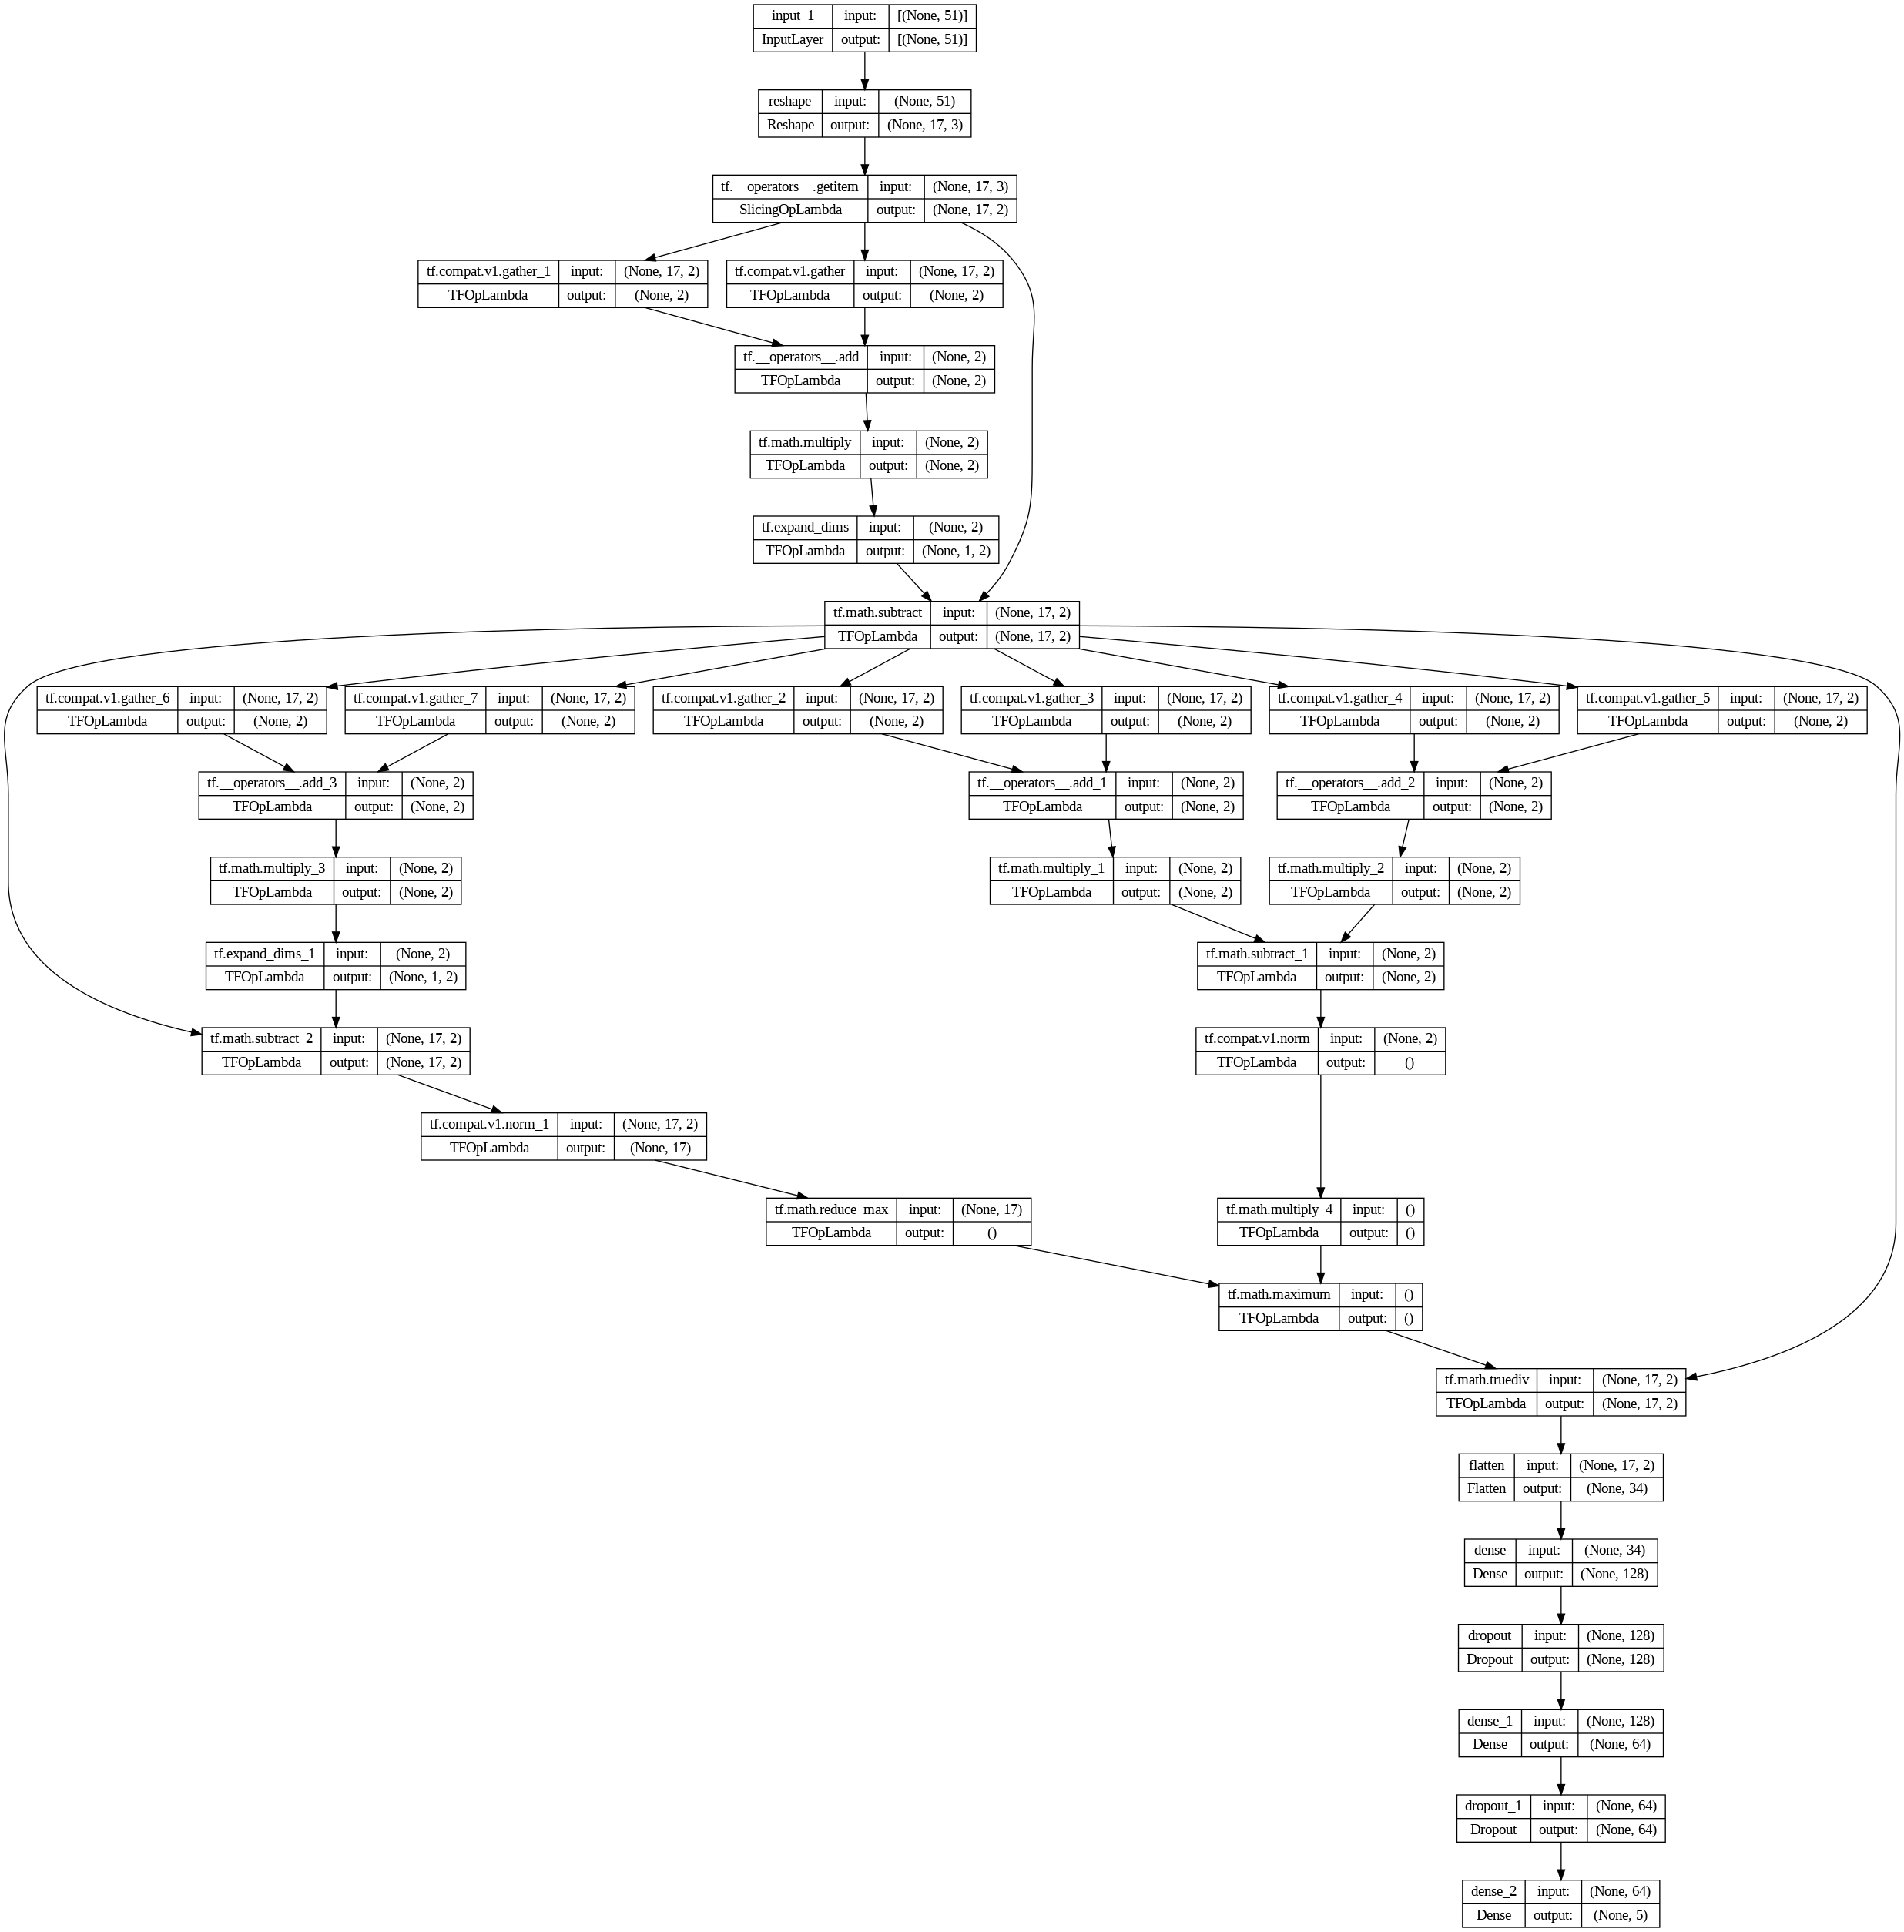

In [12]:
# Model Visualization
from keras.utils import plot_model
from IPython.display import Image

# Assuming 'model' is your Keras model
# Define a set of layers you want to exclude
exclude_layers = {'Reshape', 'Dropout', 'Flatten', 'TFOpLambda'}

# Function to check if a layer should be displayed
def is_displayed(layer):
    return layer.__class__.__name__ not in exclude_layers

# Create a filtered list of layers to display
display_layers = [layer for layer in model.layers if is_displayed(layer)]

# Plot the filtered model (this is a workaround and might not work directly as expected)
for layer in display_layers:
    print(f"{layer.name} (type: {layer.__class__.__name__}):")
    print(f"    Input shape: {layer.input_shape}")
    print(f"    Output shape: {layer.output_shape}")
    print(f"    Trainable: {layer.trainable}")
    if hasattr(layer, 'units'):
        print(f"    Units: {layer.units}")
    if hasattr(layer, 'activation'):
        print(f"    Activation: {layer.activation.__name__}")
    print()

# Save the plot to a file
plot_model(model, to_file='filtered_model.png', show_shapes=True, show_layer_names=True)

# Display the plot
Image(filename='filtered_model.png')


Epoch 1/20
49/52 [===========================>..] - ETA: 0s - loss: 1.5399 - accuracy: 0.3597
Epoch 1: val_accuracy improved from -inf to 0.45890, saving model to weights.best.hdf5
52/52 [==============================] - 3s 17ms/step - loss: 1.5346 - accuracy: 0.3710 - val_loss: 1.3989 - val_accuracy: 0.4589
Epoch 2/20
28/52 [===============>..............] - ETA: 0s - loss: 1.2910 - accuracy: 0.5536

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/52 [======================>.......] - ETA: 0s - loss: 1.2545 - accuracy: 0.5351
Epoch 2: val_accuracy improved from 0.45890 to 0.59589, saving model to weights.best.hdf5
52/52 [==============================] - 0s 7ms/step - loss: 1.2244 - accuracy: 0.5414 - val_loss: 1.0380 - val_accuracy: 0.5959
Epoch 3/20
38/52 [====================>.........] - ETA: 0s - loss: 0.9760 - accuracy: 0.6431
Epoch 3: val_accuracy improved from 0.59589 to 0.77397, saving model to weights.best.hdf5
52/52 [==============================] - 0s 7ms/step - loss: 0.9541 - accuracy: 0.6460 - val_loss: 0.7952 - val_accuracy: 0.7740
Epoch 4/20
40/52 [======================>.......] - ETA: 0s - loss: 0.7683 - accuracy: 0.7219
Epoch 4: val_accuracy improved from 0.77397 to 0.82877, saving model to weights.best.hdf5
52/52 [==============================] - 0s 7ms/step - loss: 0.7684 - accuracy: 0.7080 - val_loss: 0.6511 - val_accuracy: 0.8288
Epoch 5/20
48/52 [==========================>...] - ETA: 0s - loss: 0.66

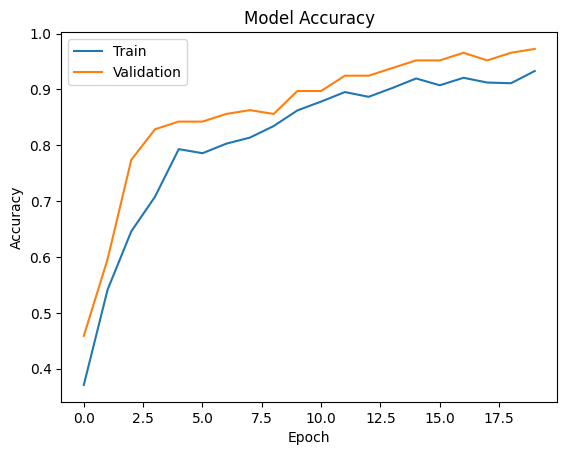

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint_path = "weights.best.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=20)

# Start training
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val), callbacks=[checkpoint, earlystopping])

# Visualize training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


16/16 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.9576
Test Loss: 0.14014258980751038, Test Accuracy: 0.9575757384300232
16/16 [==============================] - 0s 2ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

       chair       0.90      1.00      0.95        84
       cobra       0.97      1.00      0.98       116
         dog       0.92      1.00      0.96        90
        tree       1.00      0.91      0.95        96
     warrior       1.00      0.89      0.94       109

    accuracy                           0.96       495
   macro avg       0.96      0.96      0.96       495
weighted avg       0.96      0.96      0.96       495



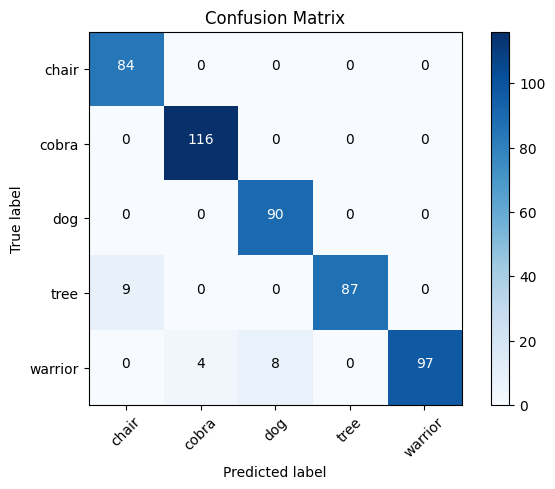

In [14]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict classes on the test dataset
y_pred = model.predict(X_test)
y_pred_label = np.argmax(y_pred, axis=1)
y_true_label = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_label, y_pred_label)

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names, normalize=False)

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label, y_pred_label, target_names=class_names))


In [15]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Assuming y_true_label and y_pred_label are your actual and predicted class labels from the model

# Generate the confusion matrix
confusion_matrix = confusion_matrix(y_true_label, y_pred_label)

# Convert the confusion matrix to a Pandas DataFrame for easier manipulation
confusion_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

# Chi-Square Test
chi2, p, dof, expected = chi2_contingency(confusion_df)

# Print the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(pd.DataFrame(expected, index=class_names, columns=class_names))

# Interpretation
significance_level = 0.05
if p < significance_level:
    print("Reject the null hypothesis - There is a significant association between the observed and expected frequencies.")
else:
    print("Fail to reject the null hypothesis - No significant association between the observed and expected frequencies.")


Chi-Square Statistic: 1782.3491168441333
P-value: 0.0
Degrees of Freedom: 16
Expected Frequencies:
             chair      cobra        dog       tree    warrior
chair    15.781818  20.363636  16.630303  14.763636  16.460606
cobra    21.793939  28.121212  22.965657  20.387879  22.731313
dog      16.909091  21.818182  17.818182  15.818182  17.636364
tree     18.036364  23.272727  19.006061  16.872727  18.812121
warrior  20.478788  26.424242  21.579798  19.157576  21.359596
Reject the null hypothesis - There is a significant association between the observed and expected frequencies.


In [16]:
X_test

,nose_x,nose_y,nose_score,left_eye_x,left_eye_y,left_eye_score,right_eye_x,right_eye_y,right_eye_score,left_ear_x,...,left_knee_score,right_knee_x,right_knee_y,right_knee_score,left_ankle_x,left_ankle_y,left_ankle_score,right_ankle_x,right_ankle_y,right_ankle_score
0,100.775160,149.454040,0.480813,95.956370,154.65329,0.666816,96.203270,144.969790,0.448191,98.673860,...,0.596673,242.13371,137.97192,0.518701,286.35980,156.75510,0.610763,283.07806,142.11703,0.707876
1,103.169910,149.453690,0.428444,98.161835,154.68036,0.513664,97.839020,145.084090,0.504177,100.808426,...,0.664031,243.47098,137.70357,0.628864,287.66486,157.65848,0.680540,283.10953,142.10999,0.661836
2,105.639570,148.838580,0.608494,100.506270,154.13074,0.689602,100.341896,144.943280,0.522742,102.821945,...,0.662215,244.63695,136.83643,0.672477,287.19135,158.66809,0.582782,283.46027,143.69876,0.725402
3,107.129750,149.385220,0.397259,102.311030,154.77415,0.433730,102.063300,145.380160,0.395607,103.883090,...,0.634880,244.72357,136.90100,0.703331,288.06200,158.89029,0.573991,283.10815,143.68346,0.703281
4,109.257750,148.598650,0.579392,104.186270,153.99712,0.567397,104.299220,144.706970,0.500572,105.545560,...,0.562615,246.84427,136.61108,0.508201,287.79517,158.47680,0.543610,282.10730,143.59535,0.680152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,127.132590,110.495316,0.390198,122.373924,110.06452,0.459560,122.990880,106.740616,0.555054,113.694855,...,0.331131,142.75966,242.76428,0.608615,255.66830,194.67828,0.812623,141.85245,277.16110,0.611812
491,126.119680,111.861210,0.331054,120.946300,110.98769,0.363766,122.369804,108.186920,0.517856,112.847786,...,0.383544,146.51547,240.35143,0.401162,257.41614,193.73695,0.776922,146.11885,278.01233,0.489120
492,125.664566,111.210560,0.322301,120.563194,109.41520,0.492237,122.236690,107.682230,0.470564,111.523850,...,0.423628,150.84668,237.66911,0.375635,258.84490,192.61813,0.651550,155.59239,279.29750,0.475286
493,122.229230,109.981710,0.371271,116.752070,109.16869,0.412598,118.297130,106.068560,0.576820,108.751600,...,0.564366,156.08894,237.87396,0.333711,258.93237,192.32648,0.715681,163.44023,279.30786,0.538141


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Predict the classes for the first five embeddings in the test set
predicted_classes = model.predict(X_test[:5])
predicted_classes = np.argmax(predicted_classes, axis=1)

# Get the actual classes for these embeddings
actual_classes = np.argmax(y_test[:5], axis=1)

# Define a function to map class indices back to class names
def index_to_class_name(index, class_names):
    return class_names[index]

# Display the actual and predicted class names for the first five test cases
for i in range(5):
    actual_class_name = index_to_class_name(actual_classes[i], class_names)
    predicted_class_name = index_to_class_name(predicted_classes[i], class_names)
    print(f"Test case {i+1}: Actual - {actual_class_name}, Predicted - {predicted_class_name}")



1/1 [==============================] - 0s 23ms/step
Test case 1: Actual - chair, Predicted - chair
Test case 2: Actual - chair, Predicted - chair
Test case 3: Actual - chair, Predicted - chair
Test case 4: Actual - chair, Predicted - chair
Test case 5: Actual - chair, Predicted - chair


# PHASE 3

In [18]:

# Convert to DataFrame
import pandas as pd
import json

# Load the JSON file
with open('/content/drive/MyDrive/endsem_Project/v5_Yoga_/Data/Phase1_output/optimal.json') as json_file:
    optimal_coordinates = json.load(json_file)

df_right = pd.DataFrame.from_dict(optimal_coordinates, orient='index', columns=['x', 'y'])




test_image_url = "https://cdn.discordapp.com/attachments/705978420089192485/1055721549996499066/cachedImage.jpg"
!wget -O /tmp/image.jpeg {test_image_url}


# Detect pose in an image
image = tf.io.read_file('/tmp/image.jpeg')
image = tf.io.decode_jpeg(image)
pose_landmarks = detect(image)


# pose_landmarks = detect(test_image_url)  # Replace with actual detection function

# Process the landmarks
landmark_data = {}
for kp in pose_landmarks.keypoints:
    landmark_data[kp.body_part.name] = (kp.coordinate.x, kp.coordinate.y)

# Convert to DataFrame
df_wrong = pd.DataFrame(landmark_data, index=['x', 'y']).transpose()


--2023-11-29 09:58:16--  https://cdn.discordapp.com/attachments/705978420089192485/1055721549996499066/cachedImage.jpg
Resolving cdn.discordapp.com (cdn.discordapp.com)... 162.159.130.233, 162.159.133.233, 162.159.134.233, ...
Connecting to cdn.discordapp.com (cdn.discordapp.com)|162.159.130.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39722 (39K) [image/jpeg]
Saving to: ‘/tmp/image.jpeg’

/tmp/image.jpeg     100%[===================>]  38.79K  --.-KB/s    in 0.01s   

2023-11-29 09:58:16 (3.28 MB/s) - ‘/tmp/image.jpeg’ saved [39722/39722]



In [19]:
df_wrong

,x,y
NOSE,147,163
LEFT_EYE,144,155
RIGHT_EYE,143,153
LEFT_EAR,125,154
RIGHT_EAR,125,153
LEFT_SHOULDER,114,177
RIGHT_SHOULDER,109,173
LEFT_ELBOW,155,140
RIGHT_ELBOW,152,137
LEFT_WRIST,174,107


In [20]:
df_right

,x,y
NOSE,147,163
LEFT_EYE,144,155
RIGHT_EYE,143,153
LEFT_EAR,125,154
RIGHT_EAR,125,153
LEFT_SHOULDER,114,177
RIGHT_SHOULDER,109,173
LEFT_ELBOW,155,140
RIGHT_ELBOW,152,137
LEFT_WRIST,120,90


from matplotlib import pyplot as plt
df_right['x'].plot(kind='hist', bins=20, title='x')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_right['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_right.plot(kind='scatter', x='x', y='y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_right['x'].plot(kind='line', figsize=(8, 4), title='x')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_right['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

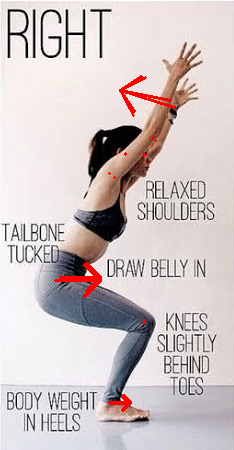

In [21]:
import cv2
from google.colab.patches import cv2_imshow

# Load the image for posture correction
image_path = '/tmp/image.jpeg'
image = cv2.imread(image_path)


# Define arrow properties
color = (0, 0, 255)  # Red color in BGR format
thickness = 2        # Thickness of the arrow line
tip_length = 0.5     # Length of the tip of the arrow


for point in df_right.index:
    start_point = (int(df_wrong.loc[point, 'x']), int(df_wrong.loc[point, 'y']))
    end_point = (int(df_right.loc[point, 'x']), int(df_right.loc[point, 'y']))
    image = cv2.arrowedLine(image, start_point, end_point, color, thickness, tipLength=0.5)

cv2_imshow(image)

